# Titanic Survival Classifier

The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean on the night of April 14-15, 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. At the time of her construction, she was the largest ship afloat and was considered the most luxurious passenger ship ever built.

The disaster was caused by a combination of factors, including the ship's speed, the lack of lifeboats, and the failure of the crew to properly manage the evacuation. The sinking of the Titanic was one of the deadliest commercial peacetime maritime disasters in modern history. It led to major changes in maritime safety regulations, including the requirement for ships to carry enough lifeboats for all passengers and crew.

In this notebook we will analyze a dataset containing information about the passengers aboard the Titanic and predict whether a passenger survived or not based on the available features.

The dataset used is from Kaggle and can be found [here](https://www.kaggle.com/datasets/yasserh/titanic-dataset).

## Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data is first cleaned by removing the columns that are not needed for the classifier. The columns that are removed are:
* PassengerId
* Name
* Ticket

The rows with missing and duplicate values are then dropped from the dataset.

In [2]:
data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)
data.drop_duplicates(inplace=True)

## Exploratory Data Analysis

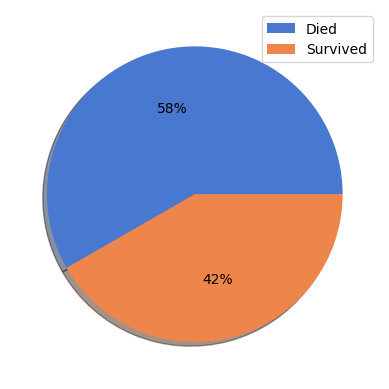

In [3]:
import seaborn as sns

counts = data.Survived.value_counts().values 
explode = (0, 0)

plt.pie(counts, explode=explode, labels=None, shadow=True, colors=sns.color_palette('muted'), autopct='%.0f%%', radius=1)
plt.legend(["Died", 'Survived'])

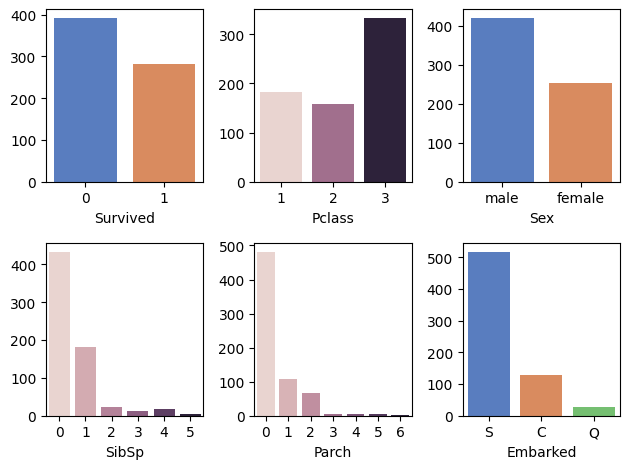

In [4]:
i = 1
sns.set_palette(sns.color_palette('muted'))
for column in ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]:
    plt.subplot(2, 3, i)
    sns.barplot(x=data[column].value_counts().index,
                y=data[column].value_counts().values, hue=data[column].value_counts().index, legend=False)
    i += 1
plt.tight_layout()
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

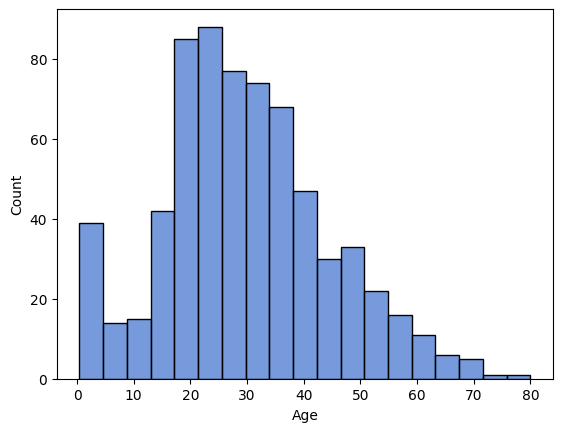

In [5]:
sns.histplot(data['Age'])

<Axes: xlabel='Fare', ylabel='Count'>

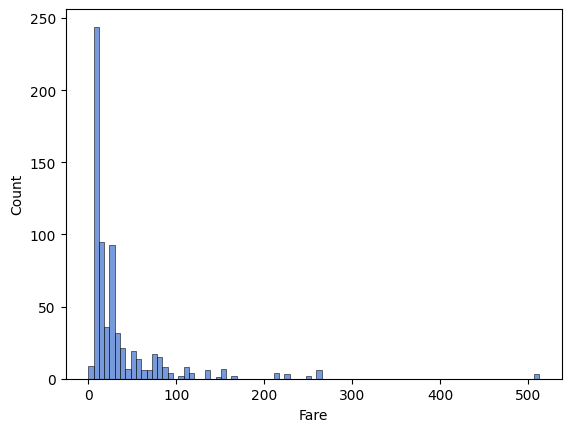

In [6]:
sns.histplot(data['Fare'])

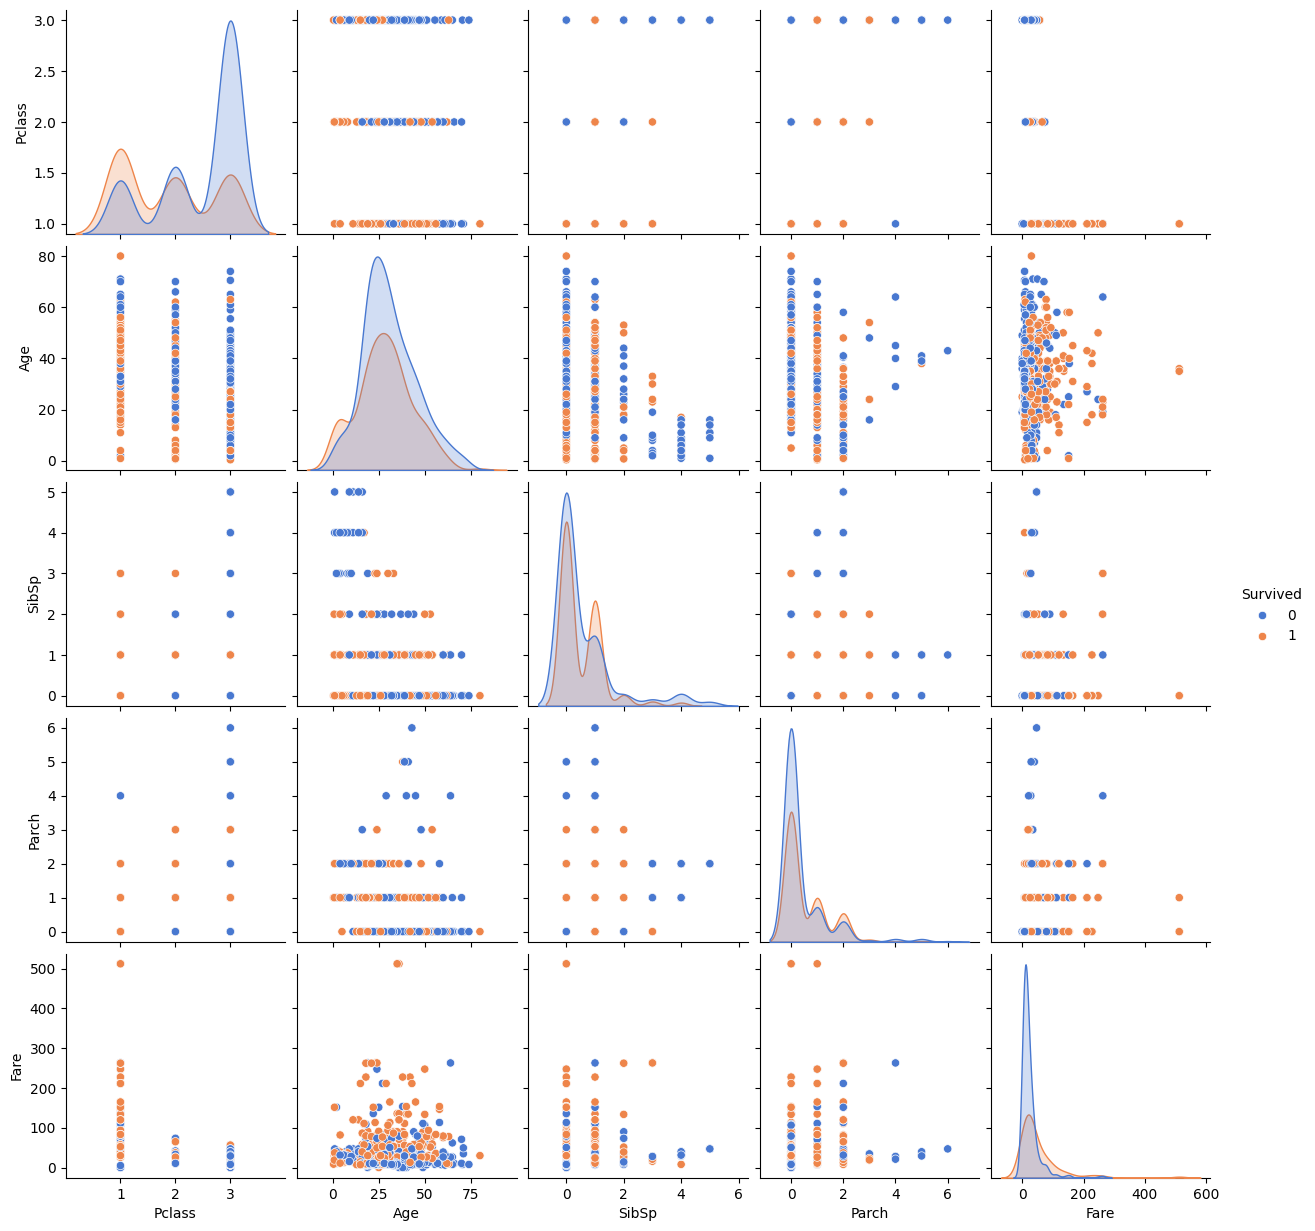

In [7]:
sns.set_palette(sns.color_palette('muted'))
sns.pairplot(data, hue='Survived')

## Data Preprocessing

The attributes with non numerical data are encoded to numerical data manually.

In [8]:
data.Sex.replace(to_replace=['male', 'female'], value=[1, 0], inplace=True)
data.Embarked.replace(to_replace=['S', 'C', 'Q'], value=[
                      0, 1, 2], inplace=True)

The rows with outliers are then dropped from the dataset.

In [9]:
for i in [i for i in data.columns]:
    if data[i].nunique() >= 12:
        Q1 = data[i].quantile(0.20)
        Q3 = data[i].quantile(0.80)
        IQR = Q3 - Q1
        data = data[data[i] <= (Q3+(1.5*IQR))]
        data = data[data[i] >= (Q1-(1.5*IQR))]
data = data.reset_index(drop=True)

SMOTE technique is used to balance the dataset to get equal number of the target variables.

In [10]:
from imblearn.over_sampling import SMOTE
x_cols = ['Pclass', 'Sex', 'Fare', 'Embarked']
y_col = 'Survived'

x = data[x_cols]
y = data[y_col]


smote = SMOTE()
X, Y = smote.fit_resample(x, y)
data = pd.DataFrame(X, columns=x_cols)
data[y_col] = Y

The data is split into training and testing sets in the ratio 80:20.

In [11]:
from sklearn.model_selection import train_test_split

x = data[x_cols]
y = data[y_col]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

The data is standardized using StandardScaler.

In [12]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

x_train_std = std.fit_transform(x_train)
x_train_std = pd.DataFrame(x_train_std, columns=x_cols)

x_test_std = std.fit_transform(x_test)
x_test_std = pd.DataFrame(x_test_std, columns=x_cols)

## Model Building and Testing

DecisionTree classifier is used to fit and predict the data.

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(x_train_std, y_train)
y_pred = clf.predict(x_test_std)

The confusion matrix and classification report are used to evaluate the model.

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        75
           1       0.79      0.81      0.80        79

    accuracy                           0.79       154
   macro avg       0.79      0.79      0.79       154
weighted avg       0.79      0.79      0.79       154



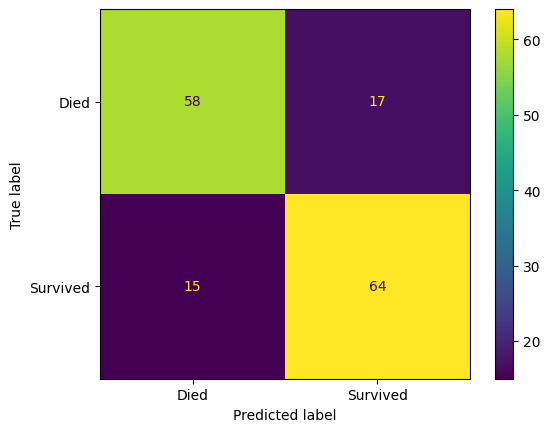

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Died', 'Survived']).plot()

## Decision Tree Visualization

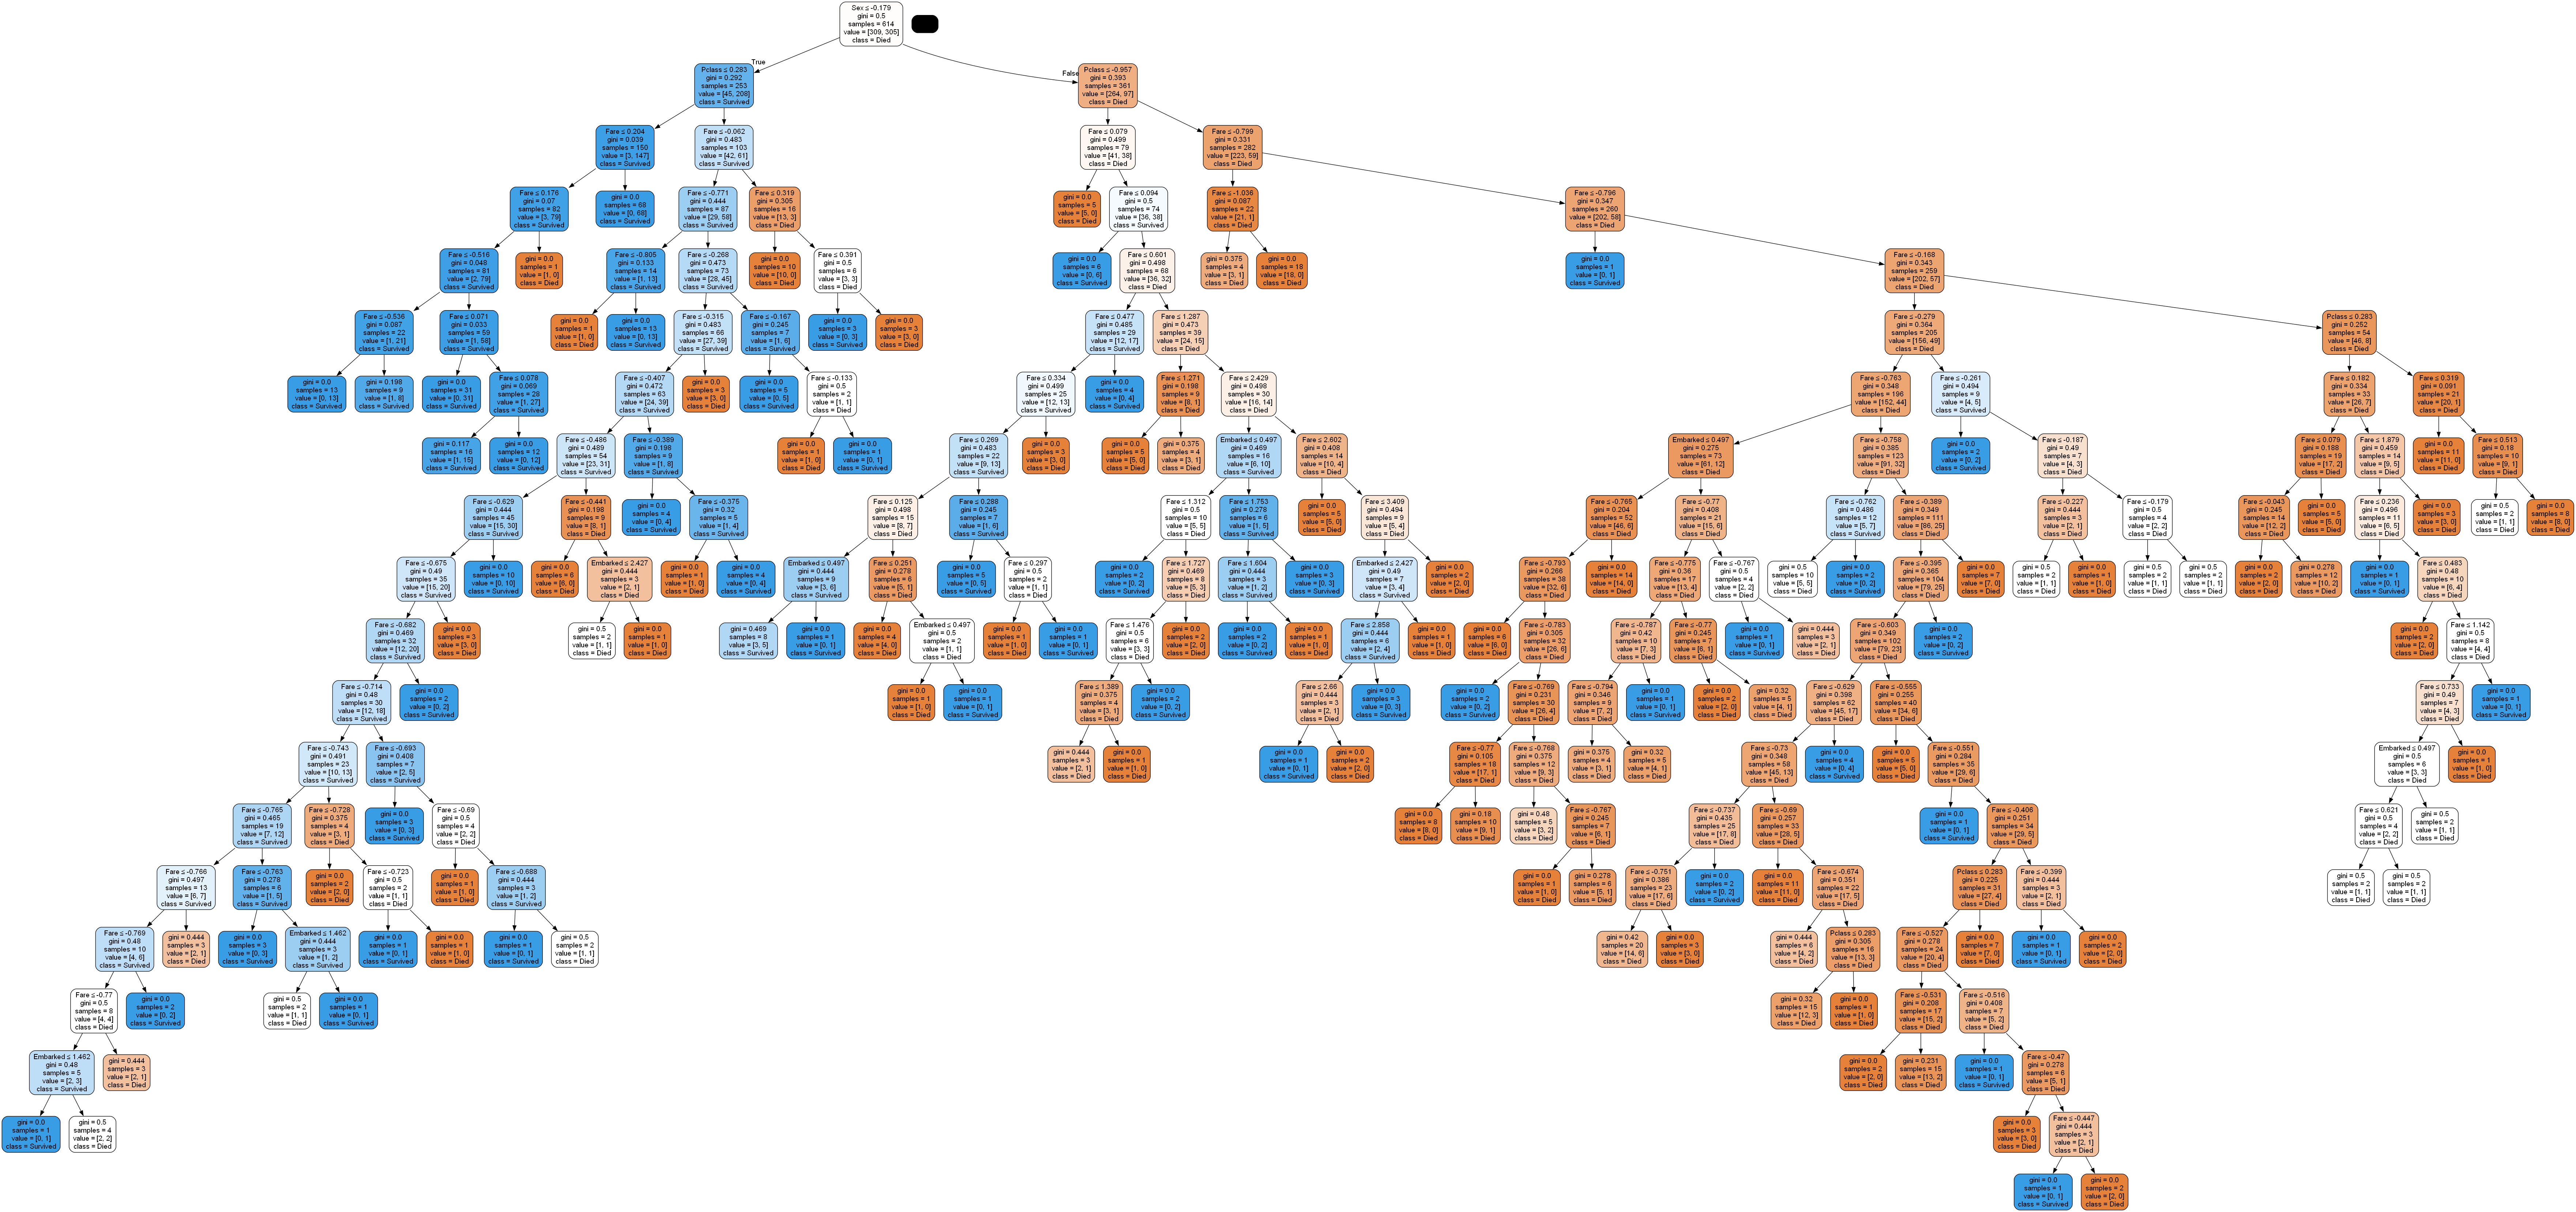

In [34]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=x_cols, class_names=['Died', 'Survived'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())